#### DRW - Crypto Market Prediction

Develop a model capable of predicting crypto future price movements.

Link to the competition: https://www.kaggle.com/competitions/drw-crypto-market-prediction/overview

The evaluation metric is: Pearson correlation coefficient (PCC)

In [1]:
import numpy as np
import polars as pls
from pathlib import Path
import lightgbm as lgb

import plotly.express as px

In [2]:
data_path = "/home/yang/team_kaggle/drw/data"

In [3]:
training_data = pls.read_parquet(Path(data_path, "train.parquet"))
# Shuffle the training set
training_data = training_data.sample(fraction=1.0, shuffle=True, seed=42)
training_data.head(10)

bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,…,X856,X857,X858,X859,X860,X861,X862,X863,X864,X865,X866,X867,X868,X869,X870,X871,X872,X873,X874,X875,X876,X877,X878,X879,X880,X881,X882,X883,X884,X885,X886,X887,X888,X889,X890,label,timestamp
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns]
10.201,3.554,137.504,477.139,614.643,0.455945,0.156054,0.22047,0.314345,0.213229,0.309831,0.342415,0.364929,0.782787,0.437171,0.558691,0.719275,0.934595,0.594639,0.624011,0.634845,1.572796,0.356922,0.610073,0.471605,0.617061,0.221393,0.160492,0.188,1.6113,0.082352,0.13999,0.225973,0.172749,-0.11272,-0.170855,-0.065223,…,1.221426,-0.186892,0.493867,-2.2141e-34,0.44962,-0.164752,0.183902,0.102021,0.0,1.592214,-0.445619,0.0,-0.086006,0.0,0.0,0.0,0.0,0.523175,0.22928,2.799699,4.053666,0.22096,0.22589,0.473638,0.521432,0.583462,1.262546,1.557144,1.471337,1.471337,1.471337,1.471337,1.468739,1.410402,2.360201,0.513817,2023-06-25 11:04:00
7.955,12.834,9.427,11.389,20.816,-0.296205,-0.077624,-0.164131,-0.217358,-0.122609,-0.111764,-0.147973,-0.194297,-0.014491,0.088987,-0.004808,0.029109,0.222959,0.209831,0.137743,0.061467,0.804471,0.133721,0.2913,0.223908,0.286692,-0.07402,-0.256348,-0.260209,1.204841,-0.052857,0.042527,0.091091,0.062379,-0.099559,-0.092654,0.013202,…,0.140121,0.10829,0.416409,-0.034783,-0.206572,0.717057,-1.53189,0.394755,0.0,1.067378,-0.441767,0.0,0.044831,0.0,0.0,0.0,0.0,0.627796,0.248407,2.636226,3.711776,0.176848,0.215451,0.533364,0.752753,1.123312,2.353131,2.262618,0.000688,0.000681,0.010116,0.060824,0.113785,0.099791,0.208067,0.639713,2023-06-16 02:41:00
16.253,8.612,316.883,69.078,385.961,-0.072822,-0.30619,0.144202,0.186061,0.052609,-0.051571,-0.082299,-0.089195,0.120548,-0.198927,0.002799,0.00918,-0.063864,-0.094576,-0.080923,-0.048403,1.11094,0.017592,0.550179,0.489121,0.66136,0.391317,0.303432,0.136173,0.952494,0.149705,0.678679,1.098371,1.323821,0.623288,0.425273,0.082367,…,0.182098,0.142667,0.368144,0.363662,0.273017,-0.554033,-0.824959,0.167162,0.0,1.160456,-0.061886,0.0,0.133485,0.0,0.0,0.0,0.0,0.679556,0.24292,2.566681,4.341193,0.446872,0.499126,1.074451,1.121207,1.136961,2.211898,2.084438,0.000714,0.000612,0.000432,0.00029,0.005688,0.02585,0.212906,-0.171524,2023-03-01 22:00:00
3.778,4.864,213.121,170.398,383.519,0.043671,-0.249998,-0.069011,0.177828,0.158949,0.163474,0.14469,0.144913,0.436186,-0.183944,0.281176,0.730603,1.035081,0.584057,0.586901,0.604066,0.059724,0.446625,1.459665,1.055542,1.283784,0.678095,0.541884,0.441548,0.559886,0.918481,0.894511,1.194638,1.420389,0.640372,0.257607,-0.003234,…,-0.212133,0.203845,0.569276,-1.407489,0.659926,-0.44841,0.340363,0.000176,0.0,0.192575,0.70822,0.0,-0.363277,0.0,0.0,0.0,0.0,0.570799,0.203565,2.924183,4.176899,0.772395,0.579167,0.863318,0.633419,0.591128,1.488359,1.745534,0.000544,0.000468,0.000496,0.003245,0.040697,0.05966,0.160684,0.031799,2023-03-24 08:56:00
5.185,5.32,72.752,15.147,87.899,0.366187,-0.846847,-0.951879,-0.682562,-0.082663,0.262573,0.254918,0.231903,0.925197,-0.439139,-0.365102,0.076913,0.70938,0.664166,0.641591,0.618421,1.385803,-0.076158,0.087634,0.170724,0.373188,0.365099,0.433553,0.507511,1.239519,-0.381761,-0.089616,0.07396,0.34021,0.452311,0.585439,0.329714,…,-0.142669,0.23923,0.397981,-0.260967,0.374333,-0.15952,0.072865,-0.618188,0.0,1.426134,0.566085,0.0,0.219349,0.0,0.0,0.0,0.0,0.429022,0.24495,2.139902,4.216017,0.385669,0.432073,0.809794,0.791336,0.823082,1.508344,1.418105,0.000448,0.000764,0.021119,0.16817,0.683066,0.960149,2.085619,-0.038752,2023-11-27 03:14:00
3.471,10.965,118.344,234.565,352.909,-0.01295,-0.916387,-1.001151,-0.979312,-0.452772,-0.310239,-0.184183,-0.082118,

In [4]:
print("Size of training data (GB):", training_data.estimated_size("gb"))

Size of training data (GB): 3.5145926401019096


In [5]:
# Count null values in each column
null_counts = training_data.select([pls.col(column).null_count().alias(column) for column in training_data.columns])
null_counts

bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,…,X856,X857,X858,X859,X860,X861,X862,X863,X864,X865,X866,X867,X868,X869,X870,X871,X872,X873,X874,X875,X876,X877,X878,X879,X880,X881,X882,X883,X884,X885,X886,X887,X888,X889,X890,label,timestamp
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
training_split = int(len(training_data) * 0.8)
validation_split = int(len(training_data) * 0.9)

In [7]:
# Set parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [8]:
#### Train a LightGBM model
evals_result = {}

train_feature_list = training_data.columns[:-2]  # Exclude 'label' and 'timestamp'

training_data_loader = lgb.Dataset(training_data.select(pls.col(train_feature_list))[:training_split],
                                   label=training_data.select(pls.col("label"))[:training_split].to_numpy())

validation_data_loader = lgb.Dataset(training_data.select(pls.col(train_feature_list))[training_split:validation_split],
                                     label=training_data.select(pls.col("label"))[training_split:validation_split].to_numpy())

model = lgb.train(params, training_data_loader, num_boost_round=10,
                  valid_sets=[training_data_loader, validation_data_loader],
                  valid_names=['train', 'val'],
                  callbacks=[lgb.early_stopping(stopping_rounds=5), lgb.record_evaluation(evals_result)],
    )

training_loss = evals_result['train']['rmse'][-1]
validation_loss = evals_result['val']['rmse'][-1]
print("Training Losses per iteration:", training_loss)
print("Validation Losses per iteration:", validation_loss)

model.save_model('drw_lgbm.txt')

/home/yang/team_kaggle/drw/DRW/.venv/lib/python3.12/site-packages/lightgbm/basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.823502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221324
[LightGBM] [Info] Number of data points in the train set: 420709, number of used features: 868
[LightGBM] [Info] Start training from score 0.036718
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[10]	train's rmse: 0.961529	val's rmse: 0.968354
Training Losses per iteration: 0.9615290700375392
Validation Losses per iteration: 0.9683535801202275


In [13]:
importances = model.feature_importance(importance_type='gain')
feature_importance_df = pls.DataFrame({
    "feature": train_feature_list,
    "importance": importances
}).sort("importance", descending=True)

feature_importance_df.head(20)

px.bar(feature_importance_df.head(20).to_pandas(), x="feature", y="importance", title="Top 20 Feature Importances (Gain)").show()

ModuleNotFoundError: pa.Table requires 'pyarrow' module to be installed

#### Model evaluation

In [15]:
# load saved model to make predictions
model = lgb.Booster(model_file='drw_lgbm.txt')

y_pred = model.predict(training_data.select(pls.col(train_feature_list))[validation_split:])
y_pred

/home/yang/team_kaggle/drw/DRW/.venv/lib/python3.12/site-packages/lightgbm/basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


array([0.1877907 , 0.02096432, 0.03427372, ..., 0.02345728, 0.01200947,
       0.00838412], shape=(52589,))

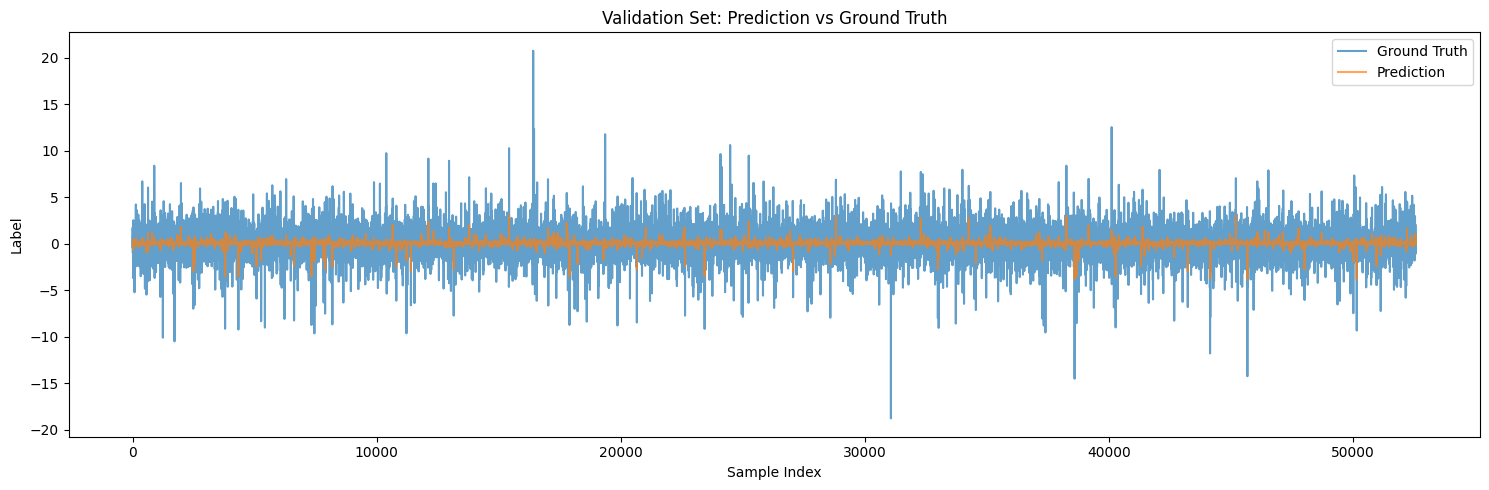

In [16]:
import matplotlib.pyplot as plt

# Get ground truth labels for the validation set
y_true = training_data.select(pls.col("label"))[validation_split:].to_numpy().flatten()

plt.figure(figsize=(15, 5))
plt.plot(y_true, label='Ground Truth', alpha=0.7)
plt.plot(y_pred, label='Prediction', alpha=0.7)
plt.title('Validation Set: Prediction vs Ground Truth')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient
pcc, _ = pearsonr(y_true, y_pred)
print("Pearson correlation coefficient (PCC):", pcc)

Pearson correlation coefficient (PCC): 0.4576587063382177


#### Predictions with test data for submission

In [20]:
testing_data = pls.read_parquet(Path(data_path, "test.parquet")).drop("label")
testing_data.head(10)

bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,…,X854,X855,X856,X857,X858,X859,X860,X861,X862,X863,X864,X865,X866,X867,X868,X869,X870,X871,X872,X873,X874,X875,X876,X877,X878,X879,X880,X881,X882,X883,X884,X885,X886,X887,X888,X889,X890
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.114,12.121,10.587,10.971,21.558,-0.732818,0.512331,-0.041982,-0.59826,-0.517646,-0.720098,-0.76901,-0.780178,-0.3365,0.249788,-0.156486,-0.495663,-0.76273,-0.471363,-0.447478,-0.408999,0.535565,-0.171083,-0.227923,-0.079453,-0.041204,0.048349,0.151941,0.240157,1.353095,-0.387866,-0.276421,-0.243297,-0.186772,0.034361,0.163524,0.166223,…,0.087326,0.602466,0.888982,0.235755,-0.074722,-1.5190e-25,0.168711,-0.033501,0.242743,-0.270279,0.0,1.051975,0.43189,0.0,-1.268835,-0.495721,1.056389,0.0,0.932371,0.243075,0.237836,1.608907,3.98586,0.306682,0.343981,0.6094,0.505601,0.43329,1.014336,1.367567,1.584126,1.584126,1.584126,1.584125,1.567979,1.426368,2.192682
2.426,2.962,136.241,12.304,148.545,-0.337995,-0.412176,-0.259468,-0.334809,-0.247443,-0.243987,-0.214849,-0.224255,-0.539625,-0.315144,-0.202614,-0.293257,-0.508739,-0.333933,-0.336385,-0.357372,-0.348564,0.065579,0.139376,-0.047501,-0.227728,-0.145745,-0.236345,-0.519209,1.102136,0.128703,0.179227,0.128473,0.023283,0.033936,-0.123918,-0.278002,…,1.111155,1.187569,0.174188,0.353079,-0.252909,0.128268,-0.502716,0.373259,0.955962,-0.356306,-0.808896,0.38169,0.718047,-1.724071,-1.204197,-0.750686,0.547839,-0.255352,0.923401,0.149122,0.210784,3.143691,3.913445,0.231629,0.312275,0.68531,0.661501,0.725448,1.748939,1.848177,0.000131,0.000323,0.001746,0.007319,0.050925,0.142206,0.739759
1.085,2.343,23.39,57.171,80.561,0.111249,0.458221,0.466916,0.574081,0.324722,0.291298,0.295451,0.324332,-0.007327,0.351338,0.358218,0.329307,0.29087,0.012313,-0.008258,0.057786,0.332306,0.167834,0.197985,0.10225,0.060063,-0.139541,-0.224249,-0.24603,0.215433,0.150163,0.046509,0.044225,0.003683,-0.21376,-0.408667,-0.295609,…,0.665538,0.589635,-0.26551,-0.340681,-0.002949,0.136127,0.273964,0.286688,-0.488119,0.268433,0.0,0.230857,0.192657,0.0,-0.618164,0.0,0.0,0.0,0.0,0.252338,0.203609,1.702517,3.665623,0.229644,0.278697,0.592664,0.629683,0.743693,1.70468,1.772028,0.00055,0.003597,0.009265,0.019948,0.072535,0.169672,0.807862
14.793,1.117,116.518,13.082,129.6,-0.149399,-0.640638,-0.873778,-1.026144,-0.508816,-0.318499,-0.27099,-0.26999,-0.206264,-0.491395,-0.791609,-0.849243,-0.737791,-0.213973,-0.258329,-0.334767,-0.501566,-0.143377,-0.101949,-0.043811,-0.021846,0.030501,-0.010734,-0.143917,1.89793,0.166798,0.151133,0.156303,0.179812,0.145286,0.095092,-0.050541,…,0.140885,0.945045,1.247777,-0.175964,-0.279785,-4.2727e-43,-0.312154,0.121647,0.145365,-0.364048,-0.39435,0.338114,0.409994,-0.88254,-2.191214,-0.716939,-0.961222,0.954427,1.652734,0.16445,0.23466,2.349036,3.508278,0.164611,0.178355,0.380719,0.406191,0.451041,0.930946,1.037839,1.382037,1.382037,1.382037,1.382037,1.381752,1.363445,2.465509
0.033,14.178,43.8,49.836,93.636,-0.694662,0.611254,0.067671,-0.531632,-0.58145,-0.670998,-0.658519,-0.641033,-0.709044,0.522476,0.176614,-0.358,-0.913063,-0.542747,-0.549789,-0.535438,-0.039,0.497418,0.220629,0.023939,-0.064359,-0.030559,-0.063269,-0.141931,2.018999,-0.201351,-0.259154,-0.308402,-0.341364,-0.106369,0.003638,0.151764,…,0.587153,0.528421,0.286078,-0.345662,-0.122057,-0.969495,0.065162,0.172275,-0.38339,0.184046,1.44023,0.815732,0.357557,-0.595227,0.096416,-0.209686,-0.4764,-1.026341,0.500108,0.255045,0.234342,2.245113,4.026028,0.576855,0.453086,0.78344,0.68716,0.602724,1.080267,1.141878,0.000363,0.012718,0.137533,0.464112,1.050577,1.268567,2.499015
1.904,1.601,27.40

In [ ]:
# predict on the test set
predictions = model.predict(testing_data.select(pls.col(train_feature_list)))
# prepare submission DataFrame
submission_df = pls.DataFrame({
    "ID": np.arange(1, len(predictions)+1),
    "prediction": predictions
})
submission_df.write_csv("submission.csv")
submission_df

ID,prediction
i64,f64
1,0.052159
2,0.084361
3,0.023598
4,0.026757
5,0.050775
…,…
538146,0.030154
538147,0.05183
538148,0.02505


In [ ]:
sample_submission = pls.read_csv(Path(data_path, "sample_submission.csv"))
sample_submission.head(10)

ID,prediction
i64,f64
1,-0.280233
2,1.371969
3,-2.045252
4,-1.447555
5,-1.303901
6,1.659284
7,1.376758
8,0.237542
9,-0.101127
